## Resource-Constrained Project Scheduling Problem with Transfer Times

This notebook demonstrates how to model and solve the Resource-Constrained Project Scheduling Problem with Sequence-Dependent Setup Times
using Constraint Programming with IBM’s CP Optimizer via the [`docplex.cp`](https://ibmdecisionoptimization.github.io/docplex-doc/cp/refman.html) Python API.
This problem extends the classical RCPSP (see [`rcpsp.ipynb`](https://github.com/radovluk/CP_Cookbook/blob/main/notebooks/rcpsp.ipynb)). [CP formulation from Vilem Heinz](https://www.overleaf.com/1895916189bqhxjfkpwvws#151a3f).

### Problem Definiton

The Resource-Constrained Project Scheduling Problem with Transfer Times (RCPSPTT) is an extension of the RCPSP problem. In RCPSP, activities are executed using available resources, precedence relationships between them must be adhered to, and the total makespan is minimized. Compared to the RCPSP, RCPSPTT introduces transfer times between activities. This means that resources do not have to be directly available after the activity that uses them finishes; rather, a transfer of resources to the following activity might be required. The transfer time depends on both the activities and the resource transferred. Formally, the RCPSPTT problem is defined as follows: Let $\mathcal{A}=\{0,1,\ldots,\hat{A}\}$, $\ \hat{A}\in\mathbb{N}$, be a set of activities with indices $i,j\in\mathcal{A}$. Let $P\in\mathbb{N}^{|\mathcal{A}|}$ be a vector of activity processing times. Let $\mathcal{E}=\{(i,j)\mid \text{activity } i \text{ precedes activity } j\}$ be a set of precedences. Let $\mathcal{R}=\{0,1,\ldots,\hat{R}\}$, $\ \hat{R}\in\mathbb{N}$, be a set of primary resources indexed by $r\in\mathcal{R}$. Let $C\in\mathbb{N}^{|\mathcal{R}|}$ be a vector of primary resource capacities. Let $\mathbf{Q}\in\mathbb{Z}_{{\ge 0}}^{|\mathcal{A}|\times|\mathcal{R}|}$ be the activity–resource consumption matrix, with entries $\mathbf{Q}_{i,r}$ denoting the consumption of resource $r$ by activity $i$ ($i=0 \Rightarrow \mathbf{Q}_{i,r}=C_r$). Let $\Delta\in\mathbb{Z}_{\ge 0}^{|\mathcal{A}|\times|\mathcal{A}|\times|\mathcal{R}|}$ be a matrix of transfer delays, with entries $\Delta_{i,j,r}$ denoting the delay required if resource $r$ is transferred between activities $i$ and $j$. Let $\mathcal{T} \subseteq \mathcal{A} \times \mathcal{A} \times \mathcal{R}$ be the set of feasible resource transfers, where $(i,j,r) \in \mathcal{T}$ if: (i) $i \neq j$ (no self-transfers), (ii) $(j,i) \notin \mathcal{E}$ (no reverse precedence relationship), (iii) either $\mathbf{Q}_{i,r} > 0$ or $i = 0$ (source activity has resource $r$), (iv) either $\mathbf{Q}_{j,r} > 0$ or $j = |\mathcal{A}|-1$ (target activity needs resource $r$ or is sink).

### CP Formulation

$$
\begin{aligned}
\min \quad
& \operatorname{end}(a_{|\mathcal{A}|-1})
\qquad &\qquad & \text{(1)} \\[2mm]
\text{s.t.} \quad
& \operatorname{endBeforeStart}(a_i, a_j),
\qquad & \forall (i, j) \in \mathcal{E}
\quad & \text{(2)} \\[1mm]
& \sum_{j:(0, j, r) \in \mathcal{T}} f_{0, j, r} = C_r,
\qquad & \forall r \in \{0, \dots, |\mathcal{R}| - 1\}
\quad & \text{(3)} \\[1mm]
& f_{i,j,r} \ge 1 \implies \operatorname{presenceOf}(z_{i,j,r}) = 1,
\qquad & \forall (i, j, r) \in \mathcal{T}, \Delta_{i,j,r} = 0
\quad & \text{(4)} \\[2mm]
& f_{i,j,r} = \operatorname{heightAtStart}(z_{i,j,r}, \operatorname{pulse}(z_{i,j,r}, (0, U_{i,j,r}))),
\qquad & \forall (i, j, r) \in \mathcal{T}, \Delta_{i,j,r} > 0
\quad & \text{(5)} \\[2mm]
& \sum_{j:(j, i, r) \in \mathcal{T}} f_{j, i, r} = Q_{i, r},
\qquad & \forall i \in \{1, \dots, |\mathcal{A}| - 1\}, \forall r \in \{0, \dots, |\mathcal{R}| - 1\}
\quad & \text{(6)} \\[2mm]
& \sum_{j:(i, j, r) \in \mathcal{T}} f_{i, j, r} = Q_{i, r},
\qquad & \forall i \in \{1, \dots, |\mathcal{A}| - 2\}, \forall r \in \{0, \dots, |\mathcal{R}| - 1\}
\quad & \text{(7)} \\[2mm]
& \operatorname{endBeforeStart}(a_i, z_{i, j, r}) \land \operatorname{endBeforeStart}(z_{i, j, r}, a_j),
\qquad & \forall (i, j, r) \in \mathcal{T}
\quad & \text{(8)} \\[2mm]
& \sum_{i: Q_{i, r} > 0} \operatorname{pulse}(a_i, Q_{i, r}) + \sum_{\substack{(i, j, k) \in \mathcal{T}, \\ \Delta_{i, j, k} > 0, k=r}} \operatorname{pulse}(z_{i, j, r}, (0, U_{i, j, r})) \le C_r,
\qquad & \forall r \in \{0, \dots, |\mathcal{R}| - 1\}
\quad & \text{(9)} \\[2mm]
& a_i: \text{mandatory interval var, length } p_i,
\qquad & \forall i \in \mathcal{A}
\quad & \text{(10a)} \\[1mm]
& f_{i,j,r} \in \mathbb{Z}, f_{i,j,r} \in [0, U_{i,j,r}],
\qquad & \forall (i, j, r) \in \mathcal{T}
\quad & \text{(10b)} \\[1mm]
& z_{i,j,r}: \text{optional interval var, length } \Delta_{i,j,r},
\qquad & \forall (i, j, r) \in \mathcal{T}
\quad & \text{(10c)}
\end{aligned}
$$

**Objective:**
  - (1) Minimize the makespan (the end time of the final sink activity $a_{|\mathcal{A}|-1}$).

**Modeling Constraints:**
  - (2) Precedence relations: Enforces precedence relations $\mathcal{E}$ between activities, ensuring an activity must finish before its successor can start.
  - (3) Source flow initialization: Ensures the total resource flow $r$ from the source node (activity 0) via all transfers ($f_{0,j,r}$) equals the total resource capacity $C_r$.
  - (4) Transfer activation for instantaneous transfers: For instantaneous transfers ($\Delta_{i,j,r} = 0$), the transfer interval $z_{i,j,r}$ is present if and only if flow $f_{i,j,r} \geq 1$ exists.
  - (5) Flow-height linkage for durative transfers: For durative transfers ($\Delta_{i,j,r} > 0$), the flow variable $f_{i,j,r}$ is constrained to equal the height of the pulse function at the start of the transfer interval $z_{i,j,r}$.
  - (6) Flow conservation (into activity): Ensures the total resource $r$ received by activity $i$ (summed from all incoming transfers) equals its required quantity $Q_{i,r}$.
  - (7) Flow conservation (out of activity): Ensures the total resource $r$ sent from activity $i$ (summed via all outgoing transfers) equals the quantity $Q_{i,r}$ that the activity processed.
  - (8) Temporal linking: Enforces the time sequencing for transfers. A transfer $z_{i,j,r}$ must start after activity $a_i$ ends, and activity $a_j$ must start after transfer $z_{i,j,r}$ ends.
  - (9) Resource capacity (cumulative constraint): Ensures that at any point in time, the sum of resources consumed by all active activities and resources in transit during active durative transfers does not exceed the capacity $C_r$ for resource $r$.

**Variable Definitions:**
  - (10a) $a_i$: A mandatory interval variable representing the execution of activity $i$ with fixed length $p_i$.
  - (10b) $f_{i,j,r}$: An integer variable representing the amount of resource $r$ flowing from activity $i$ to activity $j$. For instantaneous transfers ($\Delta_{i,j,r}=0$), linked to presence via constraint (4). For durative transfers ($\Delta_{i,j,r}>0$), linked to the pulse height via constraint (5).
  - (10c) $z_{i,j,r}$: An optional interval variable representing the transfer of resource $r$ from activity $i$ to activity $j$, with fixed length $\Delta_{i,j,r}$.

**Helper Expressions:**
  - $\operatorname{pulse}(z_{i,j,r}, (0, U_{i,j,r}))$: Creates a step function over the interval $z_{i,j,r}$ with variable height in range $[0, U_{i,j,r}]$.
  - $\operatorname{heightAtStart}(z_{i,j,r}, \operatorname{pulse}(z_{i,j,r}, (0, U_{i,j,r})))$: Returns the height of the pulse function at the start of interval $z_{i,j,r}$. Returns 0 if $z_{i,j,r}$ is absent.

**Parameters (Input Data):**
  - $\mathcal{A}$: The set of activities (including source activity 0 and sink activity $|\mathcal{A}|-1$).
  - $\mathcal{E}$: The set of precedence relations (ordered pairs of activities).
  - $\mathcal{R}$: The set of primary resources.
  - $\mathcal{T}$: The set of feasible transfers (triples of source activity, target activity, resource).
  - $p_i$: The fixed processing time (duration) of activity $a_i$.
  - $C_r$: The maximum capacity available for resource $r$.
  - $\Delta_{i,j,r}$: The duration (delay) for a transfer $(i, j, r)$. If $\Delta_{i,j,r} = 0$, the transfer is instantaneous.
  - $U_{i,j,r}$: The upper bound (maximum flow capacity) of the transfer $(i, j, r)$.
  - $Q_{i,r}$: The quantity of resource $r$ required by/consumed by activity $i$ (with $Q_{0,r} = C_r$ for the source).

#### Symbols and Notation

| Symbol / Function | Meaning | DOcplex reference | OptalCP reference |
|---|---|---|---|
| $\mathcal{A}$ | Set of activities (including source and sink) | — | — |
| $\mathcal{R}$ | Set of primary resources | — | — |
| $\mathcal{E}$ | Set of precedence relations; $(i,j) \in \mathcal{E}$ means activity $i$ must precede $j$ | — | — |
| $\mathcal{T}$ | Set of feasible resource transfers $(i,j,r)$ | — | — |
| $p_i$ | Processing time (duration) of activity $i$ | — | — |
| $C_r$ | Available capacity of resource $r$ | — | — |
| $\mathbf{Q}_{i,r}$ | Units of resource $r$ required by activity $i$ | — | — |
| $\Delta_{i,j,r}$ | Transfer delay (duration) for resource $r$ from activity $i$ to $j$ | — | — |
| $U_{i,j,r}$ | Upper bound (max flow capacity) for transfer $(i,j,r)$ | — | — |
| $a_i$ | Mandatory interval variable for activity $i$ | [docplex.cp.expression.interval_var](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.expression.py.html#docplex.cp.expression.interval_var) | [interval_var](https://optalcp.com/docs/api/classes/IntervalVar) |
| $f_{i,j,r}$ | Integer variable: amount of resource $r$ flowing from activity $i$ to $j$ | [docplex.cp.modeler.integer_var](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.integer_var) | [int_var](https://optalcp.com/docs/api/classes/Model#intvar) |
| $z_{i,j,r}$ | Optional interval variable for durative transfer of resource $r$ from $i$ to $j$ | [docplex.cp.expression.interval_var](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.expression.py.html#docplex.cp.expression.interval_var) | [interval_var](https://optalcp.com/docs/api/classes/IntervalVar) |
| $\operatorname{end}(a_i)$ | End time of activity $i$ | [docplex.cp.modeler.end_of](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.end_of) | [interval_var.end](https://optalcp.com/docs/api/classes/IntervalVar#end) |
| $\operatorname{endBeforeStart}(a_i, a_j)$ | Enforce activity $j$ to start after activity $i$ ends | [docplex.cp.modeler.end_before_start](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.end_before_start) | [interval_var.end_before_start](https://optalcp.com/docs/api/classes/IntervalVar#endbeforestart) |
| $\operatorname{pulse}(a_i, \mathbf{Q}_{i,r})$ | Time-varying resource usage: $\mathbf{Q}_{i,r}$ units during activity $i$ | [docplex.cp.modeler.pulse](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.pulse) | [interval_var.pulse](https://optalcp.com/docs/api/classes/IntervalVar#pulse) |
| $\operatorname{pulse}(z_{i,j,r}, f_{i,j,r})$ | Step function for transfer: contributes $f_{i,j,r}$ units during $z_{i,j,r}$ | [docplex.cp.modeler.pulse](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.pulse) | [interval_var.pulse](https://optalcp.com/docs/api/classes/IntervalVar#pulse) |
| $\operatorname{heightAtStart}(z, p)$ | Returns height of pulse function $p$ at start of interval $z$ | [docplex.cp.modeler.height_at_start](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.height_at_start) | *Not available* (use optional int_var directly as pulse height and synchronize presence with interval_var) |
| $\operatorname{presenceOf}(z_{i,j,r})$ | Returns 1 if optional interval $z_{i,j,r}$ is present, else 0 | [docplex.cp.modeler.presence_of](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.presence_of) | [interval_var.presence](https://optalcp.com/docs/api/classes/IntervalVar#presence) |
| $\operatorname{if\_then}(c, t)$ / $c \Rightarrow t$ | Logical implication: if condition $c$ is true, then $t$ must be true | [docplex.cp.modeler.if_then](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.if_then) | [model.implies](https://optalcp.com/docs/api/classes/Model#implies) |
| $\sum$ (cumulative sum) | Sum of pulse functions (for resource capacity constraints) | [docplex.cp.modeler.sum](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.sum) | [cumul_sum](https://optalcp.com/docs/api/classes/Model#cumulsum) |
| $\min \operatorname{end}(a_{\|\mathcal{A}\|-1})$ | Objective: minimize makespan (end time of sink activity) | [docplex.cp.modeler.minimize](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.minimize) | [model.minimize](https://optalcp.com/docs/api/classes/Model#minimize) |

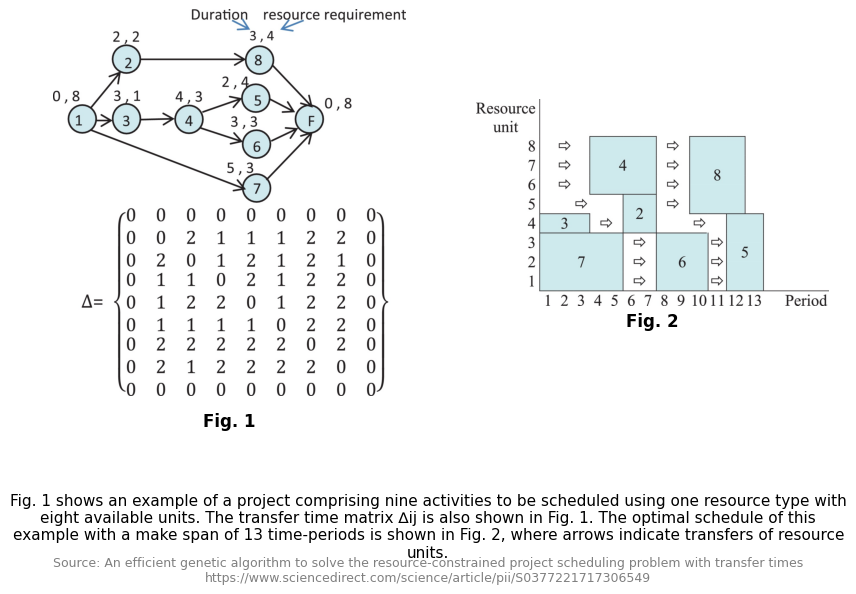

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import textwrap
img_problem = mpimg.imread('../data/rcpsptt/problem_visualisation.jpg')
img_solution = mpimg.imread('../data/rcpsptt/solution_visualisation.jpg')
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].imshow(img_problem)
axes[0].axis('off')
axes[0].set_title("Fig. 1", y=-0.1, fontsize=12, fontweight='bold')
axes[1].imshow(img_solution)
axes[1].axis('off')
axes[1].set_title("Fig. 2", y=-0.14, fontsize=12, fontweight='bold')
description = (
    "Fig. 1 shows an example of a project comprising nine activities to be scheduled "
    "using one resource type with eight available units. The transfer time matrix ∆ij "
    "is also shown in Fig. 1. The optimal schedule of this example with a make span "
    "of 13 time-periods is shown in Fig. 2, where arrows indicate transfers of resource units."
)
wrapped_description = textwrap.fill(description, width=110)
fig.text(0.5, 0.15, wrapped_description, ha='center', va='top', fontsize=11, wrap=True)
citation_text = (
    "Source: An efficient genetic algorithm to solve the resource-constrained project scheduling problem with transfer times\n"
    "https://www.sciencedirect.com/science/article/pii/S0377221717306549"
)
fig.text(0.5, 0.02, citation_text, ha='center', va='bottom', fontsize=9, color='gray')
plt.subplots_adjust(bottom=0.25)
plt.show()

### Data Import & Parsing

In [2]:
import re
from pathlib import Path

#### Parsing the data file

In [3]:
def parse_rcpsp_psplib(filepath):
    """
    Parses a .sm file (PSPLIB format for RCPSP with transfer times)
    and returns a dictionary with the project data.
    """
    with open(filepath, 'r') as f:
        content = f.read()

    data = {}
    match = re.search(r'jobs \(incl\. supersource/sink \):\s*(\d+)', content)
    data['n_jobs'] = int(match.group(1)) if match else 0
    match = re.search(r' - renewable\s*:\s*(\d+)', content)
    data['n_resources'] = int(match.group(1)) if match else 0
    n_jobs = data['n_jobs']
    n_res = data['n_resources']
    data['precedence_arcs'] = []
    prec_start = content.find('PRECEDENCE RELATIONS:')
    prec_end = content.find('****************', prec_start)
    prec_section = content[prec_start:prec_end]
    
    for line in prec_section.splitlines()[2:]:
        if not line.strip():
            continue
        parts = [int(p) for p in line.strip().split()]
        predecessor = parts[0]
        successors = parts[3:]
        for succ in successors:
            # Convert 1-based index from file to 0-based index
            data['precedence_arcs'].append((predecessor - 1, succ - 1))

    data['durations'] = []
    data['demands'] = []
    req_start = content.find('REQUESTS/DURATIONS:')
    req_end = content.find('****************', req_start)
    req_section = content[req_start:req_end]

    for line in req_section.splitlines()[3:]:
        if not line.strip():
            continue
        parts = [int(p) for p in line.strip().split()]
        data['durations'].append(parts[2])
        data['demands'].append(parts[3:]) # The rest are resource demands

    cap_start = content.find('RESOURCEAVAILABILITIES:')
    cap_end = content.find('****************', cap_start)
    cap_section = content[cap_start:cap_end]

    cap_line = cap_section.splitlines()[2]
    data['capacities'] = [int(p) for p in cap_line.strip().split()]
    data['transfer_times'] = []
    current_pos = cap_end

    for _ in range(n_res):
        tt_start = content.find('TRANSFERTIMES', current_pos)
        tt_end = content.find('****************', tt_start)
        tt_section = content[tt_start:tt_end]
        
        matrix = []
        lines = tt_section.splitlines()[3:]
        
        for i in range(n_jobs):
            line = lines[i]
            parts = [int(p) for p in line.strip().split()]
            matrix.append(parts[1:])
            
        data['transfer_times'].append(matrix)
        current_pos = tt_end
    return data

#### Helper functions and data structures

In [4]:
def compute_transitive_closure(edges, n_jobs):
    """
    Computes the transitive closure of the precedence graph using Floyd-Warshall algorithm. 
    Returns all precedence relationships (both direct and transitive) as (i, j) tuples.
    """
    adj = [[False] * n_jobs for _ in range(n_jobs)]
    for i, j in edges:
        adj[i][j] = True
    # Floyd-Warshall
    for k in range(n_jobs):
        for i in range(n_jobs):
            for j in range(n_jobs):
                adj[i][j] = adj[i][j] or (adj[i][k] and adj[k][j])
    return [(i, j) for i in range(n_jobs) for j in range(n_jobs) if adj[i][j]]

def compute_possible_transfers(abs_A, abs_R, Q, C, E, max_flow_limit=1000):
    """
    Generates the set T (feasible transfers) and calculates U (upper bounds).
    Returns: Dictionary mapping (i, j, r) -> U_ijr
    """
    T = {}
    E_set = set(E)  # Convert once for O(1) lookups
    for i in range(abs_A):
        for j in range(abs_A):
            if i == j or (j, i) in E_set:  # Skip self-transfers and reverse precedence
                continue
            for r in range(abs_R):
                # Check feasibility conditions
                source_has_resource = (i == 0 or Q[i][r] > 0)
                target_needs_resource = (j == abs_A - 1 or Q[j][r] > 0)
                if source_has_resource and target_needs_resource:
                    # Calculate upper bound U_ijr
                    max_flow = C[r] if i == 0 else min(Q[i][r], C[r])
                    T[(i, j, r)] = min(max_flow, max_flow_limit)
    return T

In [5]:
filename = "../data/rcpsptt/j301_a.sm"
filepath = Path(filename)

# Parse data
data = parse_rcpsp_psplib(filepath)
abs_A = data['n_jobs']
abs_R = data['n_resources']
p = data['durations']
C = data['capacities']  # List of capacities
Q = data['demands']  # List of lists (activity x resource demands)
E = compute_transitive_closure(data['precedence_arcs'], abs_A)

# This is IMPORTANT!
# Enforce Q[0,r] = Cr and Q[last,r] = Cr
Q[0] = C[:]
Q[abs_A - 1] = C[:]

# data['transfer_times'] is [resource][from_activity][to_activity]
Delta = []
for i in range(abs_A):
    Delta.append([])
    for j in range(abs_A):
        Delta[i].append([])
        for r in range(abs_R):
            Delta[i][j].append(data['transfer_times'][r][i][j])

T = compute_possible_transfers(abs_A, abs_R, Q, C, E)

### IBM CPO DOcplex Implementation

#### Imports

In [6]:
from docplex.cp.model import CpoModel

#### Create model and variables

In [7]:
mdl = CpoModel(name='rcpsptt_cpo')

# (10a): a_i (mandatory interval variables)
a = [mdl.interval_var(size=p[i], name=f'a_{i}') for i in range(abs_A)]

# (10b): f_{i,j,r} (integer flow variables)
f = {(i, j, r): mdl.integer_var(min=0, max=U_ijr, name=f'f_{i}_{j}_{r}')
     for (i, j, r), U_ijr in T.items()}

# (10c): z_{i,j,r}
z = {(i, j, r): mdl.interval_var(size=Delta[i][j][r], optional=True,
                                 name=f'z_{i}_{j}_{r}')
     for (i, j, r) in T.keys()}

In [8]:
# helper: store pulse expressions for cumulative constraint (Eq 9)
cumulative_contributions = {(i, j, r): mdl.pulse(z[(i, j, r)], (0, T[(i, j, r)]))
                            for (i, j, r) in T.keys() if Delta[i][j][r] > 0}

#### Add constraints and define objective

In [9]:
# (1): Minimize makespan
mdl.add(mdl.minimize(mdl.end_of(a[abs_A - 1])))

In [10]:
# (2) Precedence relations
mdl.add([mdl.end_before_start(a[i], a[j]) for i, j in E])

# (3) Source flow initialization
for r in range(abs_R):
    if outgoing := [f[(0, j, r)] for j in range(abs_A) if (0, j, r) in T]:
        mdl.add(mdl.sum(outgoing) == C[r])

# (4) Implication for instantaneous transfers (Delta = 0)
mdl.add(mdl.if_then(f[(i, j, r)] >= 1, mdl.presence_of(z[(i, j, r)]))
        for (i, j, r) in T.keys() if Delta[i][j][r] == 0)

# (5) Flow-height linkage for durative transfers
for (i, j, r), pulse in cumulative_contributions.items():
    mdl.add(f[(i, j, r)] == mdl.height_at_start(z[(i, j, r)], pulse))

# (6) Flow conservation (into activity)
for i in range(1, abs_A):
    for r in range(abs_R):
        if Q[i][r] > 0:
            if incoming := [f[(j, i, r)] for j in range(abs_A) if (j, i, r) in T]:
                mdl.add(mdl.sum(incoming) == Q[i][r])

# (7) Flow conservation (out of activity)
for i in range(1, abs_A - 1):
    for r in range(abs_R):
        if Q[i][r] > 0:
            if outgoing := [f[(i, j, r)] for j in range(abs_A) if (i, j, r) in T]:
                mdl.add(mdl.sum(outgoing) == Q[i][r])

# (8) Temporal linking for transfers
for (i, j, r) in T.keys():
    mdl.add(mdl.end_before_start(a[i], z[(i, j, r)]))
    mdl.add(mdl.end_before_start(z[(i, j, r)], a[j]))

# (9) Resource capacity (cumulative constraint)
for r in range(abs_R):
    activity_pulses = [mdl.pulse(a[i], Q[i][r]) for i in range(abs_A) if Q[i][r] > 0]
    transfer_pulses = [pulse for (i, j, res), pulse in cumulative_contributions.items() if res == r]
    if pulses := activity_pulses + transfer_pulses:
        mdl.add(mdl.sum(pulses) <= C[r])

#### Solve the model

In [11]:
print("Solving model...")
if solution := mdl.solve(TimeLimit=300, LogVerbosity='Quiet'):
    makespan = solution.get_objective_values()[0]
    print("\n" + "="*80)
    print(f"{'RCPSPTT SOLUTION':^80}")
    print("="*80)
    print(f"Instance: {filepath.name}")
    print(f"Jobs: {abs_A} | Resources: {abs_R} | Makespan: {solution.get_objective_values()}")
    print("="*80)

Solving model...

                                RCPSPTT SOLUTION                                
Instance: j301_a.sm
Jobs: 32 | Resources: 4 | Makespan: (57,)


#### Visualisation

In [12]:
print(f"\n{'ACTIVITY SCHEDULE':^80}\n{'-'*80}")
print(f"{'Job':<8} {'Start':<10} {'End':<10} {'Duration':<10} {'Resource Demands'}\n{'-'*80}")
for i in range(abs_A):
    s, e, dur = solution[a[i]].start, solution[a[i]].end, p[i]
    demands = " | ".join([f"R{r}:{Q[i][r]}" for r in range(abs_R) if Q[i][r] > 0]) or "—"
    print(f"a_{i:<5} {s:<10} {e:<10} {dur:<10} {demands}")
print(f"\n{'-'*80}\n{'RESOURCE TRANSFERS':^80}\n{'-'*80}")
active_transfers = []
for (i,j,r) in z.keys():
    try:
        trans, flow = solution[z[(i,j,r)]], solution[f[(i,j,r)]]
        if trans.is_present() and flow > 0:
            active_transfers.append((r, trans.start, i, j, trans.end, int(Delta[i,j,r]), flow))
    except: pass
if active_transfers:
    for r in range(abs_R):
        r_trans = sorted([t for t in active_transfers if t[0] == r], key=lambda x: x[1])
        if r_trans:
            print(f"\nResource R{r} (Cap: {C[r]}): {'Transfer':<12} {'Start':<8} {'End':<8} {'Δ':<6} {'Flow'}")
            for _, start, i, j, end, dur, flow in r_trans:
                print(f"  z_{i}_{j}_{r:<7} {start:<8} {end:<8} {dur:<6} {flow}")
    print(f"\nTotal: {len(active_transfers)} transfers")
else:
    print("  No active transfers (all instantaneous)")
print(f"\n{'-'*80}\n{'SOLUTION SUMMARY':^80}\n{'-'*80}")
print(f"  Makespan: {makespan} | Activities: {abs_A} | Transfers: {len(active_transfers)} | Resources: {abs_R} | Precedences: {len(E)}")
print("="*80 + "\n")


                               ACTIVITY SCHEDULE                                
--------------------------------------------------------------------------------
Job      Start      End        Duration   Resource Demands
--------------------------------------------------------------------------------
a_0     0          0          0          R0:11 | R1:12 | R2:9 | R3:9
a_1     0          4          4          R0:1
a_2     0          3          3          R3:2
a_3     0          10         10         R3:4
a_4     4          14         10         R2:1
a_5     40         45         5          R1:10
a_6     4          5          1          R1:3
a_7     7          14         7          R0:3
a_8     14         18         4          R3:1
a_9     42         47         5          R3:6
a_10    14         21         7          R3:6
a_11    21         31         10         R1:3
a_12    18         20         2          R1:7
a_13    26         30         4          R2:2
a_14    30         35        

### OptalCP Implementation

$$
\begin{aligned}
\min \quad
& \operatorname{end}(a_{|\mathcal{A}|-1})
\qquad &\qquad & \text{(1)} \\[2mm]
\text{s.t.} \quad
& \operatorname{endBeforeStart}(a_i, a_j),
\qquad & \forall (i, j) \in \mathcal{E}
\quad & \text{(2)} \\[1mm]
& \sum_{j:(0, j, r) \in \mathcal{T}} f_{0, j, r} = C_r,
\qquad & \forall r \in \{0, \dots, |\mathcal{R}| - 1\}
\quad & \text{(3)} \\[1mm]
& \operatorname{presenceOf}(f_{i,j,r}) = \operatorname{presenceOf}(z_{i,j,r}),
\qquad & \forall (i, j, r) \in \mathcal{T}
\quad & \text{(4)} \\[2mm]
& \sum_{j:(j, i, r) \in \mathcal{T}} f_{j, i, r} = Q_{i, r},
\qquad & \forall i \in \{1, \dots, |\mathcal{A}| - 1\}, \forall r \in \{0, \dots, |\mathcal{R}| - 1\}
\quad & \text{(5)} \\[2mm]
& \sum_{j:(i, j, r) \in \mathcal{T}} f_{i, j, r} = Q_{i, r},
\qquad & \forall i \in \{1, \dots, |\mathcal{A}| - 2\}, \forall r \in \{0, \dots, |\mathcal{R}| - 1\}
\quad & \text{(6)} \\[2mm]
& \operatorname{endBeforeStart}(a_i, z_{i, j, r}) \land \operatorname{endBeforeStart}(z_{i, j, r}, a_j),
\qquad & \forall (i, j, r) \in \mathcal{T}
\quad & \text{(7)} \\[2mm]
& \sum_{i: Q_{i, r} > 0} \operatorname{pulse}(a_i, Q_{i, r}) + \sum_{\substack{(i, j, k) \in \mathcal{T}, \\ \Delta_{i, j, k} > 0, k=r}} \operatorname{pulse}(z_{i, j, r}, f_{i,j,r}) \le C_r,
\qquad & \forall r \in \{0, \dots, |\mathcal{R}| - 1\}
\quad & \text{(8)} \\[2mm]
& a_i: \text{mandatory interval var, length } p_i,
\qquad & \forall i \in \mathcal{A}
\quad & \text{(9a)} \\[1mm]
& f_{i,j,r}: \text{optional integer var}, f_{i,j,r} \in [1, U_{i,j,r}],
\qquad & \forall (i, j, r) \in \mathcal{T}
\quad & \text{(9b)} \\[1mm]
& z_{i,j,r}: \text{optional interval var, length } \Delta_{i,j,r},
\qquad & \forall (i, j, r) \in \mathcal{T}
\quad & \text{(9c)}
\end{aligned}
$$

Changes from DOcplex to OptalCP formulation:

- **(4)**: Replaced `heightAtStart` (not available in OptalCP) with presence synchronization between flow variable and transfer interval. The original implication constraint `f ≥ 1 ⟹ presence(z)` is now redundant since `f ∈ [1, U]` and presence synchronization together ensure: transfer exists ⟺ flow is present ⟺ flow ≥ 1.
- **(8)**: Pulse height is now the flow variable `f_{i,j,r}` directly, instead of fixed range `(0, U_{i,j,r})`.
- **(9b)**: Flow variables `f_{i,j,r}` are now optional with domain `[1, U_{i,j,r}]` to enable presence synchronization.

#### Imports

In [13]:
import optalcp as cp

#### Create model and variables

In [14]:
mdl = cp.Model(name='rcpsptt_optal')

# (9a): a_i (mandatory interval variables)
a = [mdl.interval_var(length=p[i], name=f'a_{i}') for i in range(abs_A)]

# (9b): f_{i,j,r} (optional integer flow variables with min=1)
f = {(i, j, r): mdl.int_var(min=1, max=U_ijr, name=f'f_{i}_{j}_{r}', optional=True)
     for (i, j, r), U_ijr in T.items()}

# (9c): z_{i,j,r} (optional interval variables for transfers)
z = {(i, j, r): mdl.interval_var(length=Delta[i][j][r], optional=True,
                                 name=f'z_{i}_{j}_{r}')
     for (i, j, r) in T.keys()}

#### Add constraints and define objective

In [15]:
# (1): Minimize makespan
mdl.minimize(a[abs_A - 1].end())

In [16]:
# (2) Precedence relations
for i, j in E:
    a[i].end_before_start(a[j])

# (3) Source flow initialization
for r in range(abs_R):
    outgoing = [f[(0, j, r)] for j in range(abs_A) if (0, j, r) in T]
    if outgoing:
        mdl.constraint(mdl.sum(outgoing) == C[r])

# (4) Presence synchronization: flow variable is present iff transfer interval is present
# This replaces heightAtStart - combined with f ∈ [1, U], it ensures:
# transfer exists ⟺ flow is present ⟺ flow ≥ 1
for (i, j, r) in T.keys():
    mdl.constraint(f[(i, j, r)].presence() == z[(i, j, r)].presence())

# (5) Flow conservation (into activity)
for i in range(1, abs_A):
    for r in range(abs_R):
        if Q[i][r] > 0:
            incoming = [f[(j, i, r)] for j in range(abs_A) if (j, i, r) in T]
            if incoming:
                mdl.constraint(mdl.sum(incoming) == Q[i][r])

# (6) Flow conservation (out of activity)
for i in range(1, abs_A - 1):
    for r in range(abs_R):
        if Q[i][r] > 0:
            outgoing = [f[(i, j, r)] for j in range(abs_A) if (i, j, r) in T]
            if outgoing:
                mdl.constraint(mdl.sum(outgoing) == Q[i][r])

# (7) Temporal linking for transfers
for (i, j, r) in T.keys():
    a[i].end_before_start(z[(i, j, r)])
    z[(i, j, r)].end_before_start(a[j])

# (8) Resource capacity (cumulative constraint)
# Use int_var directly as pulse height - this replaces heightAtStart
for r in range(abs_R):
    activity_pulses = [mdl.pulse(a[i], Q[i][r]) for i in range(abs_A) if Q[i][r] > 0]
    transfer_pulses = [mdl.pulse(z[(i, j, r)], f[(i, j, r)]) 
                       for (i, j, res) in T.keys() 
                       if res == r and Delta[i][j][r] > 0]
    all_pulses = activity_pulses + transfer_pulses
    if all_pulses:
        mdl.constraint(mdl.cumul_sum(all_pulses) <= C[r])

In [17]:
# (1): Minimize makespan
mdl.minimize(a[abs_A - 1].end())

#### Solve the model

In [18]:
# Winning strategy
params = cp.Parameters()
params.timeLimit = 60
params.nbWorkers = 8
params.logLevel = 2
params.logPeriod = 5
params.usePrecedenceEnergy = 1
params.searchType = "FDSLB"
params.fdsLBStrategy = "Split"
params.noOverlapPropagationLevel = 4
params.cumulPropagationLevel = 3
params.reservoirPropagationLevel = 2

result = cp.solve(mdl, params=params)
if result.best_solution is not None:
    print(f"Makespan: {result.best_solution.get_objective()}")
else:
    print("No solution found")

--------------------------------------------------------------------------------
                         ScheduleOpt OptalCP [Academic]
                           Version 2025.11.1 (Linux)
                CPU: AMD Ryzen 5 5500U with (12 physical cores)
--------------------------------------------------------------------------------
Input parse time: 00:00
Parameters:
   NbWorkers = 8
   SearchType = FDSLB
   LogPeriod = 5 seconds
   TimeLimit = 60 seconds
   NoOverlapPropagationLevel = 4
   CumulPropagationLevel = 3
   ReservoirPropagationLevel = 2
   UsePrecedenceEnergy = 1
   FDSLBStrategy = Split
Input: rcpsptt_optal
   236 integer variables, 268 interval variables, 986 constraints, 257kB
   00:00 Presolving..
Presolved:
   236 integer variables, 268 interval variables, 1052 constraints, 255kB
   00:00 Starting the search using 8 workers (nbWorkers parameter).
--------------------------------------------------------------------------------
   00:00 Lower bound 40 Worker 0
   00:00 

### Aditional Resources

- **Instances for RCPSPTT:** https://www2.informatik.uni-osnabrueck.de/kombopt/data/rcpsp/

- **For image of the problem instance see this article:** [An efficient genetic algorithm to solve the resource-constrained project scheduling problem with transfer times](https://www.sciencedirect.com/science/article/pii/S0377221717306549)

- [Problem defintion from Vilem Heinz](https://www.overleaf.com/1895916189bqhxjfkpwvws#151a3f).